<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Mon Mar 13 14:38:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:2D:00.0 Off |                  N/A |
| N/A   55C    P8    N/A /  N/A |    119MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code


1.12.1


## 1. What are 3 areas in industry where computer vision is currently being used?

1. Autonomous driving
2. Factory anomaly detection
3. China CCTV surveilance

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

Overfitting means the model is trained on training set `too` well ,but the performance on the test set and generalization power are relatively poor.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

1. Regularization
2. Cross validation
3. Early stopping

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [18]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.MNIST(train=True, transform=ToTensor(), target_transform=None,  download=True, root = './data/')
test_data = datasets.MNIST(train=False, transform=ToTensor(), target_transform=None,  download=True, root='./data/')

## 6. Visualize at least 5 different samples of the MNIST training dataset.

torch.Size([1, 28, 28])


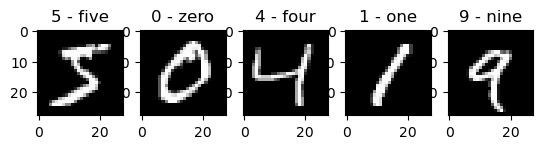

In [40]:
for i in range(5):
  plt.subplot(1,5,i+1)
  img, label = train_data[i]
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(train_data.classes[label])
print(img.shape)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [46]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, batch_size = 32)
test_dataloader = DataLoader(dataset=test_data, batch_size=32)
train_classes = train_data.classes
test_classes = test_data.classes

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [102]:
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=(3,3), stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3,3), stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_layer2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3,3), stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3,3), stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=49*hidden_units, out_features=output_shape)
    )
  def forward(self, x:torch.Tensor):
    #print(x.shape)
    x = self.conv_layer1(x)
    #print(x.shape)
    x = self.conv_layer2(x)
    #print(x.shape)
    #print(x.flatten().shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [103]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

model_2 = TinyVGG(input_shape=1, hidden_units=10, output_shape=len(train_classes))
img,label = train_data[0]
img.unsqueeze(dim=0).shape
model_2(img.unsqueeze(dim=0))


tensor([[-0.0127,  0.0260,  0.0440,  0.0179, -0.0193, -0.0362,  0.0303,  0.0112,
         -0.0350, -0.0346]], grad_fn=<AddmmBackward0>)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [104]:
# setup essential functions and metrics
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_2.parameters(), lr = 0.1)
accuracy_fn = accuracy_fn

In [109]:
from timeit import Timer as timer

train_start_cpu = timer()

epochs = 5
device = 'cpu'
train_acc, train_loss = 0,0
for epoch in range(epochs):
  model_2.train()
  for X,y in train_dataloader:
    train_logit = model_2(X)
    train_pred = train_logit.softmax(dim=0).argmax(dim=1)
    train_acc +=accuracy_fn(y_true=y, y_pred = train_pred)
    loss = loss_fn(train_logit, y)
    train_loss+=loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  print(f"train loss : {train_loss:.5f} | train_acc : {train_acc:.2f}")

KeyboardInterrupt: 

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?